In [1]:
allure_etudier=2

In [2]:
import  sys

#LOCALISATION DES DONNEES
sys.path.insert(0, "C:/projets_python/diabolo")

import warnings
warnings.filterwarnings("ignore")



#LIBRAIRIES PERSO
import etude_variable.MyLog as log
import etude_variable.jouer as jouer
import etude_variable.lecture_data as ld
import etude_variable.analyse as ana

# LIBRAIRIE PYHTON CLASSIQUES
import pandas as pd
import numpy as np
import matplotlib
import scipy
import platform

from collections import Counter

#ESTIMATEUR
import sklearn
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn import neighbors, datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer

from scipy.stats import uniform
from scipy.stats import randint

#TRAINING
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
import dask_searchcv as dcv
from skopt.space import Real, Integer

#Evaluateur
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.feature_selection import SelectFromModel


from evolutionary_search import EvolutionaryAlgorithmSearchCV
from sklearn.utils import class_weight

#outils
from dask.diagnostics import ProgressBar
import logging
from datetime import datetime


#Metriques
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import learning_curve
from sklearn import  metrics
from sklearn.metrics import  roc_auc_score
from sklearn.metrics import  classification_report

#Outils

import time


#Graphique
from matplotlib import pyplot
from matplotlib import pyplot as plt
import seaborn as sns

print('Operating system version....', platform.platform())
print("Python version is........... %s.%s.%s" % sys.version_info[:3])
print('scikit-learn version is.....', sklearn.__version__)
print('pandas version is...........', pd.__version__)
print('numpy version is............', np.__version__)
print('matplotlib version is.......', matplotlib.__version__)
print('scipy version is.......', scipy.__version__)


Operating system version.... Windows-10-10.0.17134-SP0
Python version is........... 3.6.5
scikit-learn version is..... 0.19.1
pandas version is........... 0.22.0
numpy version is............ 1.14.2
matplotlib version is....... 2.2.0
scipy version is....... 1.0.0


# LECTURE DES DONNEES

In [3]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        print(start_time)
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
        

def afficheEvalSet(mybest_model,
                    set_train,
                   set_train_cible,
                   set_test,
                   set_test_cible,
                   mode_debug=0,
                   type_eval=1):

    print("\nEVAL SET ....")

    set_test_cible_predicted = mybest_model.predict(set_test)
    set_train_cible_predicted = mybest_model.predict(set_train)

    if type_eval==1:
                print("Evaluation TEST-----------------------------------------------------------------------")
                set_test_cible_probabilities = mybest_model.predict_proba(set_test)
                score = set_test_cible_probabilities[:, 1]
                auc = roc_auc_score(set_test_cible, set_test_cible_predicted)
                print("TEST roc_auc_score :  %s" % auc)
    else:
                set_train_cible_probabilities = mybest_model.predict_proba(set_train)
                auc = roc_auc_score(set_train_cible, set_train_cible_predicted)
                print("TRAINING roc_auc_score :  %s" % auc)
    
    for x, y in [(set_train, set_train_cible), (set_test, set_test_cible)]:
            yp = mybest_model.predict(x)
            cm = confusion_matrix(y, yp.ravel())
            print(cm)

    import matplotlib.pyplot as plt

    
    
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    if type_eval==1:
        ntotal = len(set_test)
        correct = set_test_cible == set_test_cible_predicted
        numCorrect = sum(correct)
        percent = round((100.0 * numCorrect) / ntotal, 3)

        log.traceLogInfo("Classification Correcte des données de test : {0:d}/{1:d}  {2:8.3f}%".format(numCorrect, ntotal, percent))

        prediction_score = 100.0 * mybest_model.score(set_test, set_test_cible)
        log.traceLogInfo('\nScore  TEST  : %8.3f  ************************' % prediction_score)
    else:
        ntotal = len(set_train)
        correct = set_train_cible== set_train_cible_predicted
        numCorrect = sum(correct)
        percent = round((100.0 * numCorrect) / ntotal, 3)

        log.traceLogInfo("\n CLASSIFICATION CORRECTE DES DONNEES DE Train  : {0:d}/{1:d}  {2:8.3f}%".format(numCorrect, ntotal, percent))

        prediction_score = 100.0 * mybest_model.score(set_train, set_train_cible)
        log.traceLogInfo('Score  TRAINING  : %8.3f  ************************' % prediction_score)


In [4]:
  # Lecture des données sans index
xnames = ['ALLURE', 'CO_DISTANCE',
              'CO_PRIX', 'HIPPO',
              'IDCOURSE', 'IDPARTCIPANT',
              'PAR_AGE', 'PAR_ARRIVE',
              'PAR_CARRIERE',
              'PAR_CARRIERE_Q',
              'PAR_CLASSE_AGE',
              'PAR_COTEDER',
              'PAR_ENT_ECART_GAGNANT',
              'PAR_ENT_RAPPORT_GAGNANT_M',
              'PAR_ENT_REU_PLACE',
              'PAR_ENT_REUSSITE_GAGNE',
              'PAR_ENT_VICTOIRE',
              'PAR_GAIN',
              'pAR_JOC_ECART_GAGNANT',
              'PAR_JOC_ECART_PLACE',
              'PAR_JOC_NB_COURSE',
              'PAR_JOC_PLACE_3P',
              'pAR_JOC_RAPPORT_GAGNANT_M',
              'PAR_JOC_REU_PLACE',
              'pAR_JOC_REUSSITE_GAGNE',
              'pAR_JOC_VICTOIRE',
              'PAR_NP',
              'PAR_NUM',
              'PAR_PLACE',
              'PAR_PLACE_Q',
              'PAR_REUSSITE_3P',
              'PAR_REUSSITE_GAGNE',
              'PAR_REUSSITE_QUINTE',
              'PAR_RUESSITE_PLACE',
              'autostart',
              'cendre',
              'grande_piste',
              'Point',
              'Nb_partant',
              'PAR_PROPRIO',
              'NOM_JOC',
              'NOM_ENTR',
              'POIDS',
              'CORDE', 'CHEVAL',
              'MUSIC_CHEVAL',
              'MUSIC_ENT',
              'MUSIC_JOC',
              'PAR_VALEUR',
              'FIN_ligne']

# Creating bins for the win column
def assign_selection(W):
    if W < 4:
        return 1
    else:
        return 0
    
    # Creating bins for the win column
def assign_selection2(W):
    if W == 1.0:
        return 1
    if W == 0.0:
        return 0



index_col = ['IDPARTCIPANT', 'IDCOURSE']
df = ld.lecture_data('d:\data_diabolo.csv', xnames, xindex_col=index_col, allure=allure_etudier, avec_index=False)

    



Lecture data d:\data_diabolo.csv


# Filtre des données  :  Allure 

In [5]:

#Filtre des données¶
df2=df[df.Point>0]
    #df = df[df.PAR_COTEDER > 0]
df2 = df2[df2.PAR_ARRIVE > 0]  # On garde la ligne qui possede information arrivée

df2 = df2.groupby("ALLURE")
df2 = df2.get_group(allure_etudier)
df2 = ld.my_drop(df2, 'ALLURE')

if allure_etudier == 2 or allure_etudier == 4 or allure_etudier == 5:
    df2 = df2[df2.POIDS > 0]
    df2 = df2[df2.POIDS < 80]
#  on a lu les données avant l 'ajout de la colonne SELECTIOB
df2['SELECTION2'] = df2['PAR_ARRIVE'].apply(assign_selection)

df2.drop(["PAR_ARRIVE"], axis=1, inplace=True)
print(df2.shape)

(178939, 36)


# Definition de la cible

In [6]:
Lib_features_df = df2.columns
xdata = df2.values
df_gagnant = pd.DataFrame(data=xdata, columns=Lib_features_df)

df_gagnant['SELECTION'] = df_gagnant['SELECTION2'].apply(assign_selection2)
df_gagnant.drop(["SELECTION2"], axis=1, inplace=True)
df_gagnant = df_gagnant.set_index(index_col)

df_gagnant_len = len(df_gagnant.columns) - 1
Lib_features = df_gagnant.columns[:df_gagnant_len]
feature_columns = Lib_features  ##<<<<<<<<<<<<<<<<
response_column = ['SELECTION']  ##<<<<<<<<<<<<<<<<
log.traceLogdebug("Features                   : %s " % Lib_features, " <<<<************")

print("(1) Shape df_gagnant  ", df_gagnant.shape,"\n")
print("(2) FEATURES ",Lib_features)
print("(3) response column ",response_column)
# df_gagnant, feature_columns, response_column, ratio SONT DEFINI


(1) Shape df_gagnant   (178939, 34) 

(2) FEATURES  Index(['CO_PRIX', 'HIPPO', 'PAR_AGE', 'PAR_CARRIERE', 'PAR_CARRIERE_Q',
       'PAR_ENT_ECART_GAGNANT', 'PAR_ENT_RAPPORT_GAGNANT_M',
       'PAR_ENT_REU_PLACE', 'PAR_ENT_REUSSITE_GAGNE', 'PAR_ENT_VICTOIRE',
       'pAR_JOC_ECART_GAGNANT', 'PAR_JOC_ECART_PLACE', 'PAR_JOC_NB_COURSE',
       'PAR_JOC_PLACE_3P', 'pAR_JOC_RAPPORT_GAGNANT_M', 'PAR_JOC_REU_PLACE',
       'pAR_JOC_REUSSITE_GAGNE', 'pAR_JOC_VICTOIRE', 'PAR_NUM', 'PAR_PLACE',
       'PAR_PLACE_Q', 'PAR_REUSSITE_3P', 'PAR_REUSSITE_GAGNE',
       'PAR_REUSSITE_QUINTE', 'PAR_RUESSITE_PLACE', 'Point', 'Nb_partant',
       'PAR_PROPRIO', 'NOM_JOC', 'NOM_ENTR', 'POIDS', 'CORDE', 'CHEVAL'],
      dtype='object')
(3) response column  ['SELECTION']


# CORRELATION


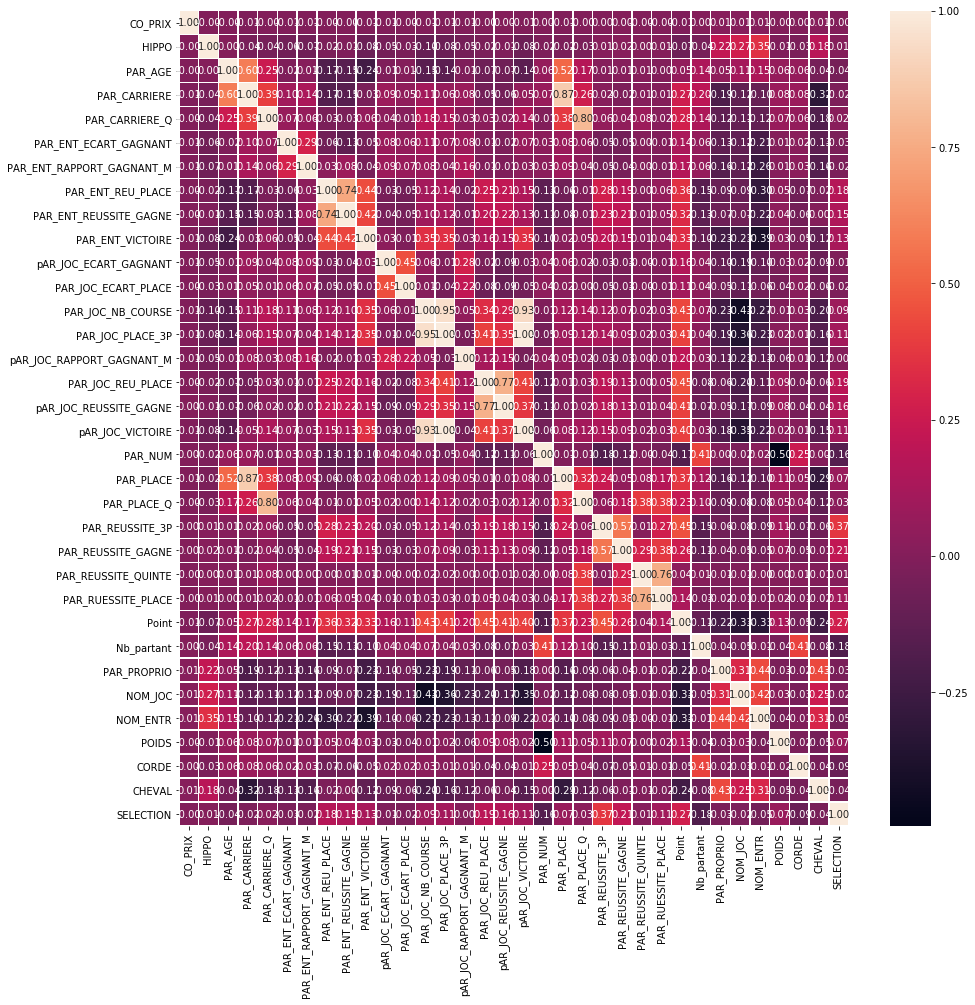

In [7]:
#Enfin, quelque chose de vraiment cool que vous pouvez mettre 

#dans une carte de chaleur est une matrice de corrélation. 
#Pandas DataFrame a une méthode corr qui calcule le coefficient de corrélation de Pearson (peut être un autre)
#entre tous les couples de colonnes numériques du DataFrame.

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_gagnant.corr(), annot=True, fmt=".2f", linewidths=.4, ax=ax)


Proportion: 2.72 : 1
Total number of records : 178939 
Nombre de participations avec SELECTION = 0 : 130884
Nombre de participations avec SELECTION = 1  : 48055
Pourcentage 0: 73.1445%,  pourcentage 1 : 26.8555%


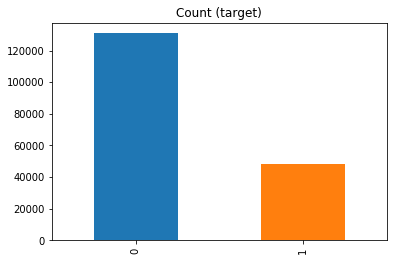

In [8]:
target_count = df_gagnant['SELECTION'].value_counts()


print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (target)')

normal_trans_perc = sum(df_gagnant['SELECTION'] == 0) / (sum(df_gagnant['SELECTION'] == 0) + sum(df_gagnant['SELECTION'] == 1))
fraud_trans_perc = 1 - normal_trans_perc
print('Total number of records : {} '.format(len(df_gagnant)))
print('Nombre de participations avec SELECTION = 0 : {}'.format(sum(df_gagnant['SELECTION'] == 0)))
print('Nombre de participations avec SELECTION = 1  : {}'.format(sum(df_gagnant['SELECTION'] == 1)))
print('Pourcentage 0: {:.4f}%,  pourcentage 1 : {:.4f}%'.format(normal_trans_perc * 100,fraud_trans_perc * 100))




# Definition des set

In [9]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(df_gagnant[feature_columns],
                                                     df_gagnant[response_column], test_size=0.33, random_state=42)
train_eval_X =  df_gagnant[feature_columns]
train_eval_Y=  df_gagnant[response_column]





print("Train_x",train_x.shape)
print("Train y",train_y.shape)
print("Test x",test_x.shape)
print("Test y",test_y.shape)

print("train_eval_X",train_eval_X.shape)
print("train_eval_Y",train_eval_Y.shape)

print("Test x",test_x.shape)
print("Test y",test_y.shape)

test_y = test_y['SELECTION'].ravel()
train_y = train_y['SELECTION'].ravel()



Train_x (119889, 33)
Train y (119889, 1)
Test x (59050, 33)
Test y (59050, 1)
train_eval_X (178939, 33)
train_eval_Y (178939, 1)
Test x (59050, 33)
Test y (59050, 1)


In [10]:
def smot2(train_x,train_y,feature_columns):
    start_time=timer()
    from imblearn.combine import SMOTEENN
    from imblearn.over_sampling import SMOTE


    #print('\nOriginal dataset shape {}'.format(Counter(train_y)))
    #sm = SMOTEENN(ratio='minority',n_jobs=3,random_state=42,n_neighbors=10 )
    sm = SMOTE(ratio='minority', n_jobs=3, random_state=42,m_neighbors=2000)


    #log.traceLogInfo("\nFIT DE SMOT2 ...equilibrage")
    X_res, y_res = sm.fit_sample(train_x, train_y)

    print('\nResampled dataset shape {}'.format(Counter(y_res)))
    # reconstitution DATAFRAME
    train_x = pd.DataFrame(X_res, columns=feature_columns)
    train_y = pd.Series(y_res)
    print("Fin SMOT")
    timer(start_time)


    return train_x,train_y

# ESTIMATEUR

In [11]:

#sample_weight = train_y.shape[0] / (2 * np.bincount(train_y))
#print("class_weight = ", sample_weight)
#sample_weight=[0.63,2.28]

kfold = StratifiedKFold(n_splits=5)
print(kfold)    

silence_esti=False


train_x, train_y = smot2(train_x=train_x, train_y=train_y, feature_columns=feature_columns)
test_x, test_y = smot2(train_x=test_x, train_y=test_y, feature_columns=feature_columns)



StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
2018-05-29 23:24:25.029089

Resampled dataset shape Counter({0: 87730, 1: 87730})
Fin SMOT

 Time taken: 0 hours 0 minutes and 1.0 seconds.
2018-05-29 23:24:26.033755

Resampled dataset shape Counter({0: 43154, 1: 43154})
Fin SMOT

 Time taken: 0 hours 0 minutes and 0.4 seconds.


In [29]:

if allure_etudier == 1:
                estimator  = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=0.9, gamma=0.3, learning_rate=0.07,
                max_delta_step=4, max_depth=10, max_features='sqrt',
                min_child_weight=13, n_estimators=2000, n_jobs=1,
                nthread=None, objective='binary:logistic', random_state=10,
                reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1, seed=400,
                silent=True, subsample=0.9)


if allure_etudier == 3:
                estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=0.9, gamma=0.3, learning_rate=0.07,
                max_delta_step=4, max_depth=10, max_features='sqrt',
                min_child_weight=13, n_estimators=1300, n_jobs=1,
                nthread=None, objective='binary:logistic', random_state=10,
                reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1, seed=400,
                silent=True, subsample=0.9)

if allure_etudier == 2:
                estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.4,
                colsample_bytree=0.9, gamma=0.3, learning_rate=0.07,
                max_delta_step=4, max_depth=10, max_features='sqrt',
                min_child_weight=13, n_estimators=1300, n_jobs=1,
                nthread=None, objective='binary:logistic', random_state=10,
                reg_alpha=0.2, reg_lambda=1.0, scale_pos_weight=1, seed=400,
                silent=True, subsample=0.9)

if allure_etudier == 4:
                 estimator =  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=0.6, gamma=0.1, learning_rate=0.07,
                max_delta_step=0, max_depth=9, max_features='sqrt',
                min_child_weight=14, n_estimators=100, n_jobs=1,
                nthread=None, objective='binary:logistic', random_state=10,
                reg_alpha=0.03, reg_lambda=1, scale_pos_weight=1, seed=27,
                silent=True, subsample=0.9)

if allure_etudier == 5:
                estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                       colsample_bytree=0.6, gamma=0.1, learning_rate=0.07,
                       max_delta_step=0, max_depth=9, max_features='sqrt',
                       min_child_weight=12, n_estimators=100, n_jobs=1,
                       nthread=None, objective='binary:logistic', random_state=10,
                       reg_alpha=0.03, reg_lambda=1, scale_pos_weight=1, seed=27,
                       silent=True, subsample=0.9)

        
model=estimator



        

In [ ]:
eval_set = [(train_x, train_y), (test_x, test_y)]
model.fit(train_x, train_y, eval_metric=["error", "auc"], eval_set=eval_set, verbose=False, early_stopping_rounds=20)

     
     

In [22]:
 y_pred = model.predict(test_x)
predictions = [round(value) for value in y_pred]


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [23]:
 # evaluate predictions
accuracy = accuracy_score(test_y, predictions)
print(">>>>>>>>>>  Accuracy: %.2f%%" % (accuracy * 100.0))
        

>>>>>>>>>>  Accuracy: 84.49%


In [24]:
    print(classification_report(test_y, predictions))

             precision    recall  f1-score   support

          0       0.80      0.92      0.86     43154
          1       0.91      0.77      0.83     43154

avg / total       0.85      0.84      0.84     86308



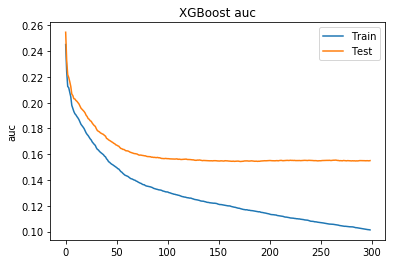

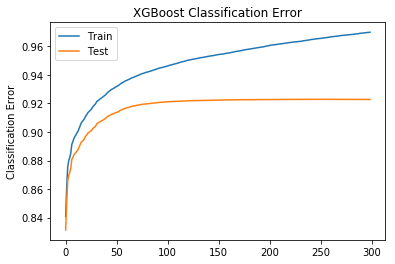


                           importance
feature                              
CHEVAL                          0.052
CO_PRIX                         0.050
NOM_JOC                         0.045
PAR_PROPRIO                     0.043
Point                           0.043
PAR_REUSSITE_3P                 0.040
NOM_ENTR                        0.039
PAR_CARRIERE                    0.038
CORDE                           0.034
PAR_ENT_RAPPORT_GAGNANT_M       0.034
PAR_RUESSITE_PLACE              0.034
Nb_partant                      0.033
pAR_JOC_RAPPORT_GAGNANT_M       0.033
HIPPO                           0.033
PAR_NUM                         0.032
PAR_REUSSITE_GAGNE              0.031
PAR_JOC_NB_COURSE               0.031
PAR_AGE                         0.029
PAR_ENT_REU_PLACE               0.029
POIDS                           0.028
PAR_JOC_REU_PLACE               0.028
PAR_JOC_ECART_PLACE             0.027
PAR_JOC_PLACE_3P                0.026
pAR_JOC_ECART_GAGNANT           0.026
PAR_PLACE  

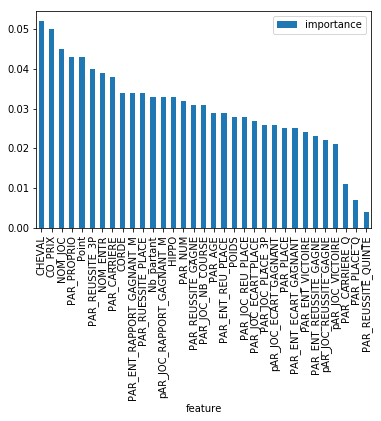

In [25]:

        # retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

 # plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('auc')
pyplot.title('XGBoost auc')
pyplot.show()

        # plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

        #Plot_predictor_importance(best_model=model, feature_columns=featurecolums)

ana.plot_importance(feature_columns=feature_columns,model=model)



EVAL SET ....


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Evaluation TEST-----------------------------------------------------------------------
TEST roc_auc_score :  0.8449390554757381


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[84731  2999]
 [14748 72982]]


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[39716  3438]
 [ 9945 33209]]
Classification Correcte des données de test : 72925/86308    84.494%


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Score  TEST  :   84.494  ************************

EVAL SET ....


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


TRAINING roc_auc_score :  0.8988544397583494


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[84731  2999]
 [14748 72982]]


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[39716  3438]
 [ 9945 33209]]

 CLASSIFICATION CORRECTE DES DONNEES DE Train  : 157713/175460    89.885%
Score  TRAINING  :   89.885  ************************


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


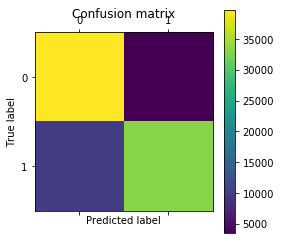

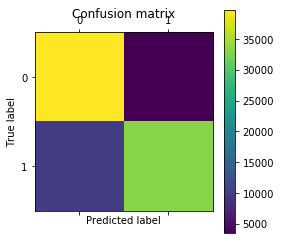

In [26]:
afficheEvalSet(model,train_x,train_y,test_x,test_y,type_eval=1)
afficheEvalSet(model,train_x,train_y,test_x,test_y,type_eval=2)

In [19]:
start_time=timer()
jouer.construireFichierCSV(allure_etudier, model, feature_columns, response_column, 0)
timer(start_time)

2018-05-29 23:28:03.176172
Lecture data d:\data_jour.csv


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Temps de calcul de la construction du fichier  est : 00:00:10


 ALLER DANS APPLICATION DIABOLO ...Allure 2

 Time taken: 0 hours 0 minutes and 10.13 seconds.
